## Import and globals

In [1]:
from IO import read_kitty, write_one_kitty
import yaml
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
from torchinfo import summary as info_summary
from itertools import chain, repeat, product, islice
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.tensorboard import SummaryWriter

config = yaml.safe_load(open('./net_config.yaml'))
print(*config.items(), sep='\n')

('generator', {'lr': 0.001})
('discriminator', {'lr': 0.001})
('data_loader', {'train': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'valid': ['11', '12', '13', '14', '15', '16', '17', '18', '20', '22', '23', '24', '26'], 'test': ['30', '34', '35', '36', '76']})
('run', {'device': 1, 'cuda': True, 'seed': 42})
('train', {'disc_loops': 2, 'batch_size': 1, 'max_epoch': 20, 'log_name': 'test', 'checkpoint': False})
('eval', {'save': 410})


## Build dataloader

In [2]:
points, labels = read_kitty(config['data_loader']['train'], max_len=1)
sample = next(iter(points['11'].values()))
print('Point cloud shape:', sample.shape)
print(*sample[:5],sep='\n')
sample = next(iter(labels['11'].values()))
print('\nLabel shape:', sample.shape)
print(*sample[:5],sep='\n')

Point cloud shape: (115881, 4)
[-197.84776     26.662176     3.9865794   13.       ]
[-197.78802     25.835665     2.8061757    6.       ]
[-197.77983     25.658987     1.0338181   10.       ]
[-197.77368     26.125235     2.2110257    9.       ]
[-197.7581      26.23899      3.3880968   13.       ]

Label shape: (115881, 2)
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]


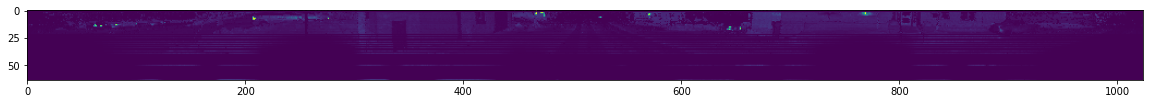

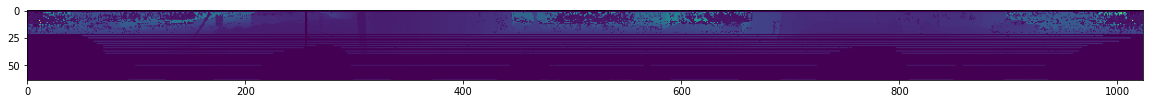

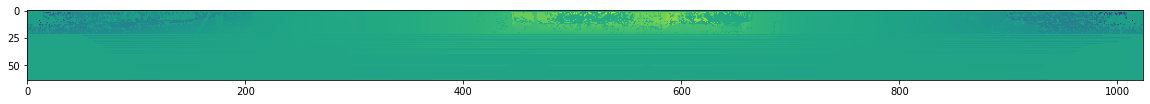

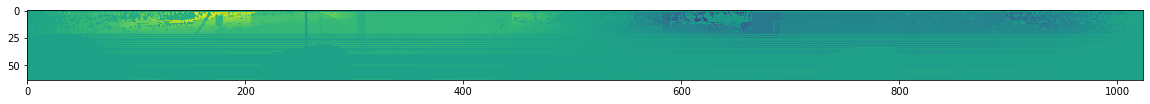

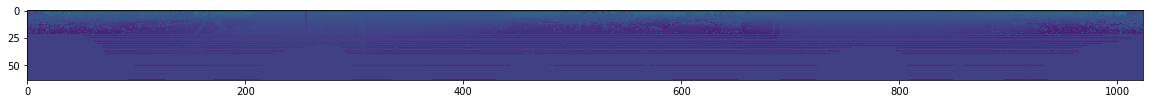

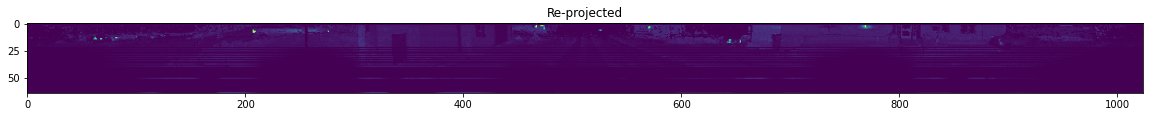

In [3]:
def project(points, vertical_fov:tuple=(3.0,-25.0), out_shape:tuple=(64,1024)):
    # unpack params to short names
    P = points.copy()
    fov_up, fov_down = vertical_fov
    height, width = out_shape
    x, y, z = P[:,0], P[:,1], P[:,2]

    # Compute spherical coordinates
    r = LA.norm(P[:,:3], 2, axis=1)
    yaw = -np.arctan2(y, x)
    pitch = np.arcsin(z / r)
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad

    # get projections in image coords
    clamp = lambda x,m: np.maximum(0, np.minimum(np.round(x),m)).astype(np.int32)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in the set [0.0, 1.0]
    proj_x *= width  # in [0.0, W]
    proj_x = clamp(proj_x, width-1) # in [0,W-1]
    
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in the set [0.0, 1.0]
    proj_y *= height  # in [0.0, H]
    proj_y = clamp(proj_y, height-1)  # in [0,H-1]

    # order in decreasing depth
    rev_indices = np.arange(r.shape[0])
    indices = np.argsort(r)[::-1]
    P, proj_y, proj_x = P[indices], proj_y[indices], proj_x[indices]
    r, rev_indices = r[indices], rev_indices[indices]
    
    # build projected image data
    proj = np.full((height, width, 6), -1, dtype=np.float32)
    proj[proj_y, proj_x, 0] = P[:,3]
    proj[proj_y, proj_x, 1] = r
    proj[proj_y, proj_x, 2:5] = P[:,0:3]
    proj[proj_y, proj_x, 5] = rev_indices
    
    return proj


def unproject(projection, vertical_fov:tuple=(3.0,-25.0), return_mask=False):
    "convert 2d image to 3d point cloud. [height, width, channels] -> [index, channels]"
    
    fov_up, fov_down = vertical_fov
    height, width, channels = projection.shape
    
    # Parameters of the LiDAR
    fov_up = fov_up / 180.0 * np.pi  # field of view up in rad
    fov_down = fov_down / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # field of view total in rad
    
    # compute point cloud
    p = -np.ones((height*width, 4), dtype=np.float32) # init as -1 to remove dead pixels later
    for y,x in product(range(height), range(width)):
        #compute target index
        index = y*width+x # or x*height+y
        
        # Get spherical coordinates
        intensity, r = projection[y, x, :2]
        if r == -1: continue # if magic number -1 then there's no data
        x /= width # normalize
        yaw = 2.0 * np.pi * (-x) 
        y /= height # normalize
        pitch = fov*(1.0-y) - abs(fov_down) - np.pi/2
        
        # Compute cartesian coordinates
        x = np.cos(yaw) * np.sin(pitch) * r
        y = np.sin(yaw) * np.sin(pitch) * r
        z = np.cos(pitch) * r
        
        # Add data to array
        p[index, 0] = x
        p[index, 1] = y
        p[index, 2] = z
        p[index, 3] = intensity
        
    mask = p[:,3]!=-1
    p = p[mask] # remove points with no data
    
    if return_mask:
        return p, mask
    return p
 
    
# print sample images to validate
%matplotlib inline
sample = next(iter(points['18'].values()))
projected = project(sample)

for i in range(0,5):
    plt.figure(figsize=(20, 6));
    plt.imshow(projected[:,:,i]);

# sanity check. intensity sum should be the same before and after
assert unproject(projected)[:,3].sum() == projected[:,:,0].sum() + sum(projected[:,:,0].flat==-1)
# sanity check. unprojected points can't be further away than max radius
assert max(projected[:,:,1].flat) > max([max(abs(unproject(projected)[:,i])) for i in range(3)])

plt.figure(figsize=(20, 6));
plt.title('Re-projected')
plt.imshow((project(unproject(projected)))[:,:,0]);

In [4]:
outlier_labels = [110] # 110 = falling snow
seq_lenths = 10 # None

# declare iterators to flatten nested dicts (sorry about the itertool mess)
flat_values = lambda points: chain(*chain((*p.values(),) for p in points.values()))
flat_keys = lambda points: chain(*chain((*zip( repeat(k, len(p.keys())), p.keys() ),) for k,p in points.items()))

# train loader
points, labels = read_kitty(config['data_loader']['train'], max_len=seq_lenths)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
snowy = [project(p)[:,:,:-4].transpose(2, 0, 1) for p in flat_values(points)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
train_loader = torch.utils.data.DataLoader(
    [*zip(clean, clean)], 
    shuffle=True, 
    batch_size=config['train']['batch_size'])
x,y = next(iter(train_loader))
print(x.shape, y.shape)

# test loader
points, labels = read_kitty(config['data_loader']['test'], max_len=None)
mask = [~np.isin(frame[:,0], outlier_labels) for frame in flat_values(labels)]
clean = [project(p[m])[:,:,:-4].transpose(2, 0, 1) for p,m in zip(flat_values(points),mask)]
snowy = [project(p)[:,:,[0,1,5]].transpose(2, 0, 1) for p in flat_values(points)] # keep last channel (rev indices)
rev_indices = [data[-1,:,:].astype(np.int32) for data in snowy] # extract reverse indices
snowy = [s[:-1,:,:] for s in snowy] # drop them
label = [lab[i].transpose(2, 0, 1) for lab,i in zip(flat_values(labels),rev_indices)] 
keys = [*flat_keys(labels)]
test_loader = torch.utils.data.DataLoader(
    [*zip(clean, clean, label, keys)],
    shuffle=False,
    batch_size=config['train']['batch_size'])
x,y,l,k = next(iter(test_loader))
print(x.shape, y.shape, l.shape, k)

torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024])
torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) torch.Size([1, 2, 64, 1024]) [('30',), ('041570',)]


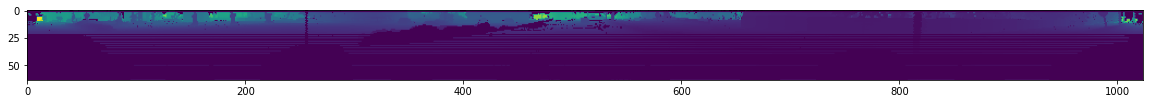

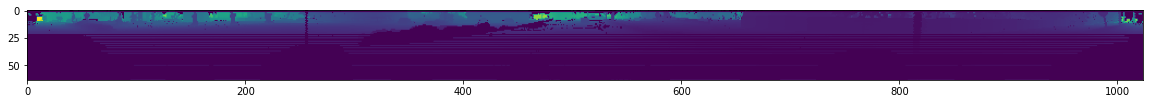

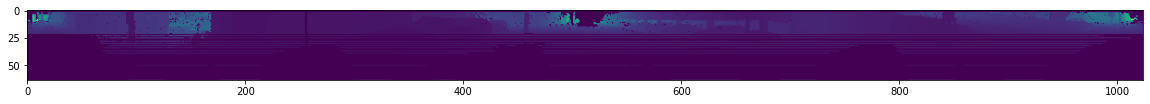

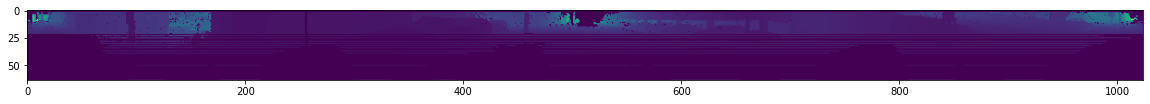

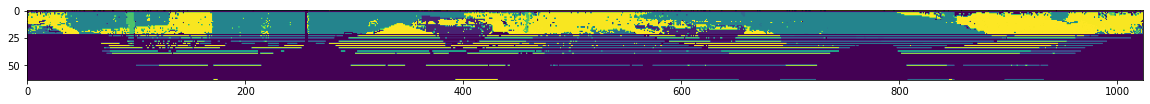

In [5]:
def display_loader(loader, plot_dim:int=1):
    x,y,*rest = next(iter(loader))
    plt.figure(figsize=(20, 6))
    plt.imshow(x[0,plot_dim,:,:]);
    plt.figure(figsize=(20, 6))
    plt.imshow(y[0,plot_dim,:,:]);
    if rest:
        l, k = rest
        plt.figure(figsize=(20, 6))
        plt.imshow(l[0,0,:,:]);
        
display_loader(train_loader)
display_loader(test_loader)

## Build net

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# Reference
# https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>
    

def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids) # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters, bias=True):
        super(ResContextBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        self.activ = nn.LeakyReLU()
        
        layers  = [nn.Conv2d(in_filters, out_filters, 1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(in_filters, out_filters, 5, padding=2, bias=bias)]
        layers += relu_and_norm()
        layers += [nn.Conv2d(out_filters, out_filters, 3, dilation=3, padding=3, bias=bias)]
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)
        resA = self.block(x)
        out = self.activ(shortcut + resA)
        return out


class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, stride=1,
                 pooling=True, drop_out:float=0.2, bias=True):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        self.activ = nn.LeakyReLU()

        layers  = [nn.Conv2d(in_filters, out_filters, 1, stride=stride, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.skip_path = nn.Sequential(*layers)

        layers  = [nn.Conv2d(in_filters, out_filters, 3, padding=1, bias=bias)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=2, padding=2, bias=bias)]
        layers += relu_and_norm()
        self.path2 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(out_filters, out_filters, 2, dilation=2, padding=1, bias=bias)]
        layers += [nn.LeakyReLU()]
        self.path3 = nn.Sequential(*layers)

        layers  = [nn.Conv2d(3*out_filters, out_filters, 1, bias=bias)]
        self.path4 = nn.Sequential(*layers)

        self.dropout = nn.Dropout2d(p=drop_out)
        if pooling:
            #self.pool = nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=1)
            layers  = [nn.PixelUnshuffle(2)]
            layers += [nn.Conv2d(4*out_filters, out_filters, 1, bias=bias)]
            layers += [nn.LeakyReLU()]
            self.pool = nn.Sequential(*layers)

    def forward(self, x):
        shortcut = self.skip_path(x)

        resA1 = self.path1(x)
        resA2 = self.path2(resA1)
        resA3 = self.path3(resA2)

        concat = torch.cat((resA1, resA2, resA3),dim=1)
        resA = self.path4(concat)
        resA += shortcut
        resA = self.activ(resA)

        resB = self.dropout(resA) if self.drop_out else resA

        if self.pooling:
            resB = self.pool(resB)
            return resB, resA
        return resB


class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, drop_out:float=None):
        super(UpBlock, self).__init__()
        relu_and_norm = lambda: [nn.LeakyReLU(), nn.BatchNorm2d(out_filters)]
        
        layers  = [nn.PixelShuffle(2)]
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        #layers += [nn.Conv2d(in_filters>>2, out_filters, 1, padding=0)]
        self.up_path = nn.Sequential(*layers)

        layers = [nn.Conv2d(in_filters//4 + 2*out_filters, out_filters, 1, padding=0)]
        layers += relu_and_norm()
        self.path1 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(out_filters, out_filters, 3, dilation=1, padding=1)]
        layers += [nn.LeakyReLU()]
        self.path2 = nn.Sequential(*layers)
        
        layers  = [nn.Conv2d(2*out_filters, out_filters, 1)]
        layers += relu_and_norm()
        layers += [nn.Dropout2d(p=drop_out)] if drop_out else []
        self.path4 = nn.Sequential(*layers)

    def forward(self, x, skip):
        upA = self.up_path(x) 
        upB = torch.cat((upA,skip),dim=1)
    
        upE1 = self.path1(upB)
        upE2 = self.path2(upE1)

        concat = torch.cat((upE1, upE2),dim=1)
        upE = self.path4(concat)
        return upE
    

class SalsaNext(nn.Module):
    def __init__(self, channels):
        super(SalsaNext, self).__init__()
        drop = False # 0.2
        
        layers  = [ResContextBlock( channels, 32)]
        layers += [ResContextBlock(32, 32)]
        self.downCntx = nn.Sequential(*layers)

        self.resBlock1 = ResBlock(1 * 32, 2 * 32, pooling=True,  drop_out=False)
        self.resBlock2 = ResBlock(2 * 32, 4 * 32, pooling=True,  drop_out=drop)
        self.resBlock3 = ResBlock(4 * 32, 8 * 32, pooling=True,  drop_out=drop)
        self.resBlock4 = ResBlock(8 * 32, 8 * 32, pooling=True,  drop_out=drop)
        
        self.resBlock5 = ResBlock(8 * 32, 8 * 32, pooling=False, drop_out=drop)

        self.upBlock1 = UpBlock(8 * 32, 4 * 32, drop_out=drop)
        self.upBlock2 = UpBlock(4 * 32, 4 * 32, drop_out=drop)
        self.upBlock3 = UpBlock(4 * 32, 2 * 32, drop_out=drop)
        self.upBlock4 = UpBlock(2 * 32, 1 * 32, drop_out=False)

        layers  = [ResContextBlock(32, 32)]
        layers += [nn.Conv2d(32, channels, 1)]
        self.reduce = nn.Sequential(*layers)
        self.reduce = nn.Conv2d(32, channels, 1)

    def forward(self, x):
        downCntx = self.downCntx(x)

        down1c, down1b = self.resBlock1(downCntx)
        down2c, down2b = self.resBlock2(down1c)
        down3c, down3b = self.resBlock3(down2c)
        down4c, down4b = self.resBlock4(down3c)
        
        down5c = self.resBlock5(down4c)

        up4e = self.upBlock1(down5c,down4b)
        up3e = self.upBlock2(up4e, down3b)
        up2e = self.upBlock3(up3e, down2b)
        up1e = self.upBlock4(up2e, down1b)
        output = self.reduce(up1e)
        
        return output

    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = SalsaNext(2)

    def forward(self, x):
        out = self.model(x)
        out[x.le(0)] = -1 # leverage that -1 input -> -1 output
        return out
    
############## Disc ##############
class mlp_block(nn.Module):
    def __init__(self, in_channels, out_channels, channel_multiplier=256):
        super(mlp_block, self).__init__()
        layers  = [nn.Conv2d(256, 1, (4,4),stride=4,padding=0)]
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        #out = torch.flatten(x)
        out = self.block(x)
        return out
    
    
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(down_block, self).__init__()
        self.pooling = kwargs.get('pooling', True)
        self.block = ResBlock(in_channels, out_channels, **kwargs)
        
    def forward(self, x):
        if self.pooling:
            return self.block(x)[0]
        return self.block(x)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        in_chnl = 2
        layer_list = [
            'cnxt-32', 'cnxt-32', 'cnxt-32', # Process context
            'downP-64', 'downPD-128', 'downPD-256', 'downPD-256', 'downD-256', # Encode
            'mlp-1', # Discriminate
        ]
        
        name2block = {
            'cnxt':  lambda i,o: ResContextBlock(i, o, bias=False),
            'downP': lambda i,o: down_block(i, o, pooling=True,  drop_out=False, bias=False),
            'downPD':lambda i,o: down_block(i, o, pooling=True,  drop_out=0.2, bias=False),
            'downD': lambda i,o: down_block(i, o, pooling=False, drop_out=0.2, bias=False),
            'mlp':   lambda i,o: mlp_block(i, o, channel_multiplier=64*4),
        }
        
        self.layers = []
        for idx, layer in enumerate(layer_list):
            block_name, out_chnl = layer.split('-')
            out_chnl = int(out_chnl)
            self.layers += [name2block[block_name](in_chnl, out_chnl)]
            in_chnl = out_chnl
        
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        out = self.layers(x)
        return out
    

def summarise():
    print('Generator\n')
    #summary(Generator().cuda(), (2, 64, 1024))
    print(info_summary(Generator().cuda(), input_size=(1, 2, 64, 1024)))

    print('\nDiscriminator\n')
    #summary(Discriminator().cuda(), (5, 64, 1024))
    print(info_summary(Discriminator().cuda(), input_size=(1, 2, 64, 1024))) # fallback if summary fails
    
summarise()

Generator

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─SalsaNext: 1-1                              [1, 2, 64, 1024]          --
│    └─Sequential: 2-1                        [1, 32, 64, 1024]         --
│    │    └─ResContextBlock: 3-1              [1, 32, 64, 1024]         11,040
│    │    └─ResContextBlock: 3-2              --                        (recursive)
│    │    └─ResContextBlock: 3-3              [1, 32, 64, 1024]         36,000
│    └─ResBlock: 2-2                          --                        (recursive)
│    └─ResBlock: 2-3                          [1, 64, 32, 512]          --
│    │    └─Sequential: 3-4                   [1, 64, 64, 1024]         2,112
│    │    └─Sequential: 3-5                   [1, 64, 64, 1024]         18,624
│    │    └─Sequential: 3-6                   [1, 64, 64, 1024]         37,056
│    │    └─Sequential: 3-7                   [

## Train net

In [7]:
import torch.optim as optim
import torchvision.transforms as transforms
import os
import cv2

# from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
# also from https://github.com/Lornatang/WassersteinGAN_GP-PyTorch/blob/master/wgangp_pytorch/utils.py
def wgangp(disc, real, fake, lambda_gp=10.0):
    "Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028"
    
    # create a mixed image from real and fake data
    alpha = torch.randn((real.size(0), 1, 1, 1), device=config['run']['device'], requires_grad=False)
    diff = fake - real
    mixed = real + alpha * diff
            
    # compute gradient penalty
    mixed.requires_grad_(True)
    disc_mixed = disc(mixed)
    grad_outputs=torch.ones(disc_mixed.size(), device=config['run']['device'], requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=disc_mixed, 
        inputs=mixed,
        grad_outputs=grad_outputs,
        create_graph=True, 
        retain_graph=True, 
        only_inputs=True
    )
    gradients = gradients[0].view(real.size(0), -1) # flaten gradients
    gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - 1) ** 2).mean() # with eps
    
    fake_loss = disc(fake.detach()).mean()
    real_loss = disc(real.detach()).mean()
    loss = fake_loss - real_loss + lambda_gp * gradient_penalty
    return loss

# Reference
# https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


class ToNumpy(object):
    def __call__(self, data):
        return data.cpu().detach().numpy().transpose(0, 2, 3, 1)


def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

                
def get_metrics(A,B):
    toNumpy = lambda x: x.cpu().detach().numpy()
    A,B = toNumpy(A), toNumpy(B)
    span = 255 # manually set! A.max()-A.min() sort of works if unkown
    # mean of funcion f applied to each channel for each image in batch
    apply = lambda f: np.mean([f(d, r, data_range=span) for da,ra in zip(A,B) for d,r in zip(da,ra)])
    metrics = { 
        'psnr_A': apply(psnr),
        'ssim_A': apply(ssim),
    }
    return metrics
        
                
# from https://github.com/leaderj1001/minimal-cyclegan/blob/master/main.py
def train(train_loader, generatorA2B, generatorB2A, discriminatorA, discriminatorB, 
          optimizerG, optimizerD, cycle, gan, identity, epoch, writer, config):
    generatorA2B.train()
    generatorB2A.train()
    discriminatorA.train()
    discriminatorB.train()
    
    tot_metrics = {}
    
    def disc_loss(disc, data, gen):
                dis_real = disc(data)
                dis_fake = disc(gen.detach())
                
                loss_D_real = gan(dis_real, torch.ones_like( dis_real))
                loss_D_fake = gan(dis_fake, torch.zeros_like(dis_fake))
                return 0.5 * (loss_D_real + loss_D_fake)
    
    for i, (dataA, dataB) in enumerate(train_loader):
        
        # Train discriminator
        set_requires_grad([discriminatorA, discriminatorB], True)
        set_requires_grad([generatorA2B, generatorB2A], False)
        
        for (dA, dB) in islice(train_loader, config['train']['disc_loops']):
            if config['run']['cuda']:
                dA = dA.to(config['run']['device'])
                dB = dB.to(config['run']['device'])

            optimizerD.zero_grad()
            genB = generatorA2B(dA)
            genA = generatorB2A(dB)
            loss_D  = disc_loss(discriminatorA, dA, genA)
            loss_D += disc_loss(discriminatorB, dB, genB)

            loss_D.backward()
            nn.utils.clip_grad_norm_(
                chain(discriminatorA.parameters(), discriminatorB.parameters()), 5)
            optimizerD.step()
        
        # Train generator
        if config['run']['cuda']:
            dataA = dataA.to(config['run']['device'])
            dataB = dataB.to(config['run']['device'])
            
        set_requires_grad([discriminatorA, discriminatorB], False)
        set_requires_grad([generatorA2B, generatorB2A], True)
            
        optimizerG.zero_grad()

        # Forward pass
        genB = generatorA2B(dataA)
        resA = generatorB2A(genB)
        genA = generatorB2A(dataB)
        resB = generatorA2B(genA)
        identity_b = generatorA2B(dataB)
        identity_a = generatorB2A(dataA)
        disA_fake = discriminatorA(genA)
        disB_fake = discriminatorB(genB)
        
        # loss
        loss_G  = 1.0 * gan(disB_fake, torch.ones_like(disB_fake))
        loss_G += 1.0 * gan(disA_fake, torch.ones_like(disA_fake))
        loss_G += 1.0 * identity(identity_a, dataA)
        loss_G += 1.0 * identity(identity_b, dataB)
        loss_G += 1.0 * cycle(dataA, resA)
        loss_G += 1.0 * cycle(dataB, resB)

        loss_G.backward()
        nn.utils.clip_grad_norm_(
            chain(generatorA2B.parameters(), generatorB2A.parameters()), 5)
        optimizerG.step()
        
        # Log train info
        metrics = {
            'Loss_disc': loss_D.item(),
            'Loss_gen': loss_G.item(),
        }
        metrics.update(get_metrics(dataA,resA))
        
        iteration = len(train_loader)*(epoch-1)+i
        for k,v in metrics.items():
            writer.add_scalars(k, {config['train']['log_name']:v}, iteration)
        
        # Display train info
        #tot_metrics = {k:tot_metrics.get(k,0) + v for k,v in metrics.items()}
        print(f'\r[Epoch: {epoch:4d}][{1+i:4d}]',
                  *[f'{k}: {v:.4f},' for k,v in metrics.items()],
                  end=' '*10)

        # Create checkpoint
        if config['train']['checkpoint']:
            if i % config['train']['checkpoint'] == 0:
                if not os.path.isdir('E:/cyclegan/checkpoints'):
                    os.mkdir('E:/cyclegan/checkpoints')

                torch.save({
                    'generatorA': generatorA2B.state_dict(),
                    'generatorB': generatorB2A.state_dict(),
                    'discriminatorA': discriminatorA.state_dict(),
                    'discriminatorB': discriminatorB.state_dict(),
                    'optimizerG': optimizerG.state_dict(),
                    'optimizerD': optimizerD.state_dict(),
                    'start_epoch': epoch,
                }, './runs/model_{}_{}.pth'.format(epoch, i))


def evaluation(test_loader, generatorA2B, generatorB2A, config):
    generatorA2B.eval()
    generatorB2A.eval()

    transform_inv = transforms.Compose([UnNormalize(mean=(0.0, 0.0), std=(1.0, 1.0)), ToNumpy()])
    toNumpy = lambda x: x.cpu().detach().numpy()
    tot_metrics = {}
    
    saved = 0
    with torch.no_grad():
        for i, (dataA, dataB, labels, keys) in enumerate(test_loader):
            
            # Forward pass
            if config['run']['cuda']:
                dataA = dataA.to(config['run']['device'])
                dataB = dataB.to(config['run']['device'])

            outB = generatorA2B(dataA)
            outA = generatorB2A(dataB)
            resB = generatorA2B(outA)
            resA = generatorB2A(outB)
            
            # display eval metrics
            metrics = {
                'mean_in':dataA.mean().item(),
                'mean_res':resA.mean().item(),
            }
            metrics.update(get_metrics(dataA,resA))
            tot_metrics = {k:tot_metrics.get(k,0) + v for k,v in metrics.items()}
            print(f'\r[Eval: {1+i:4d}]',
                  *[f'{k}: {v/(1+i):.4f},' for k,v in tot_metrics.items()],
                  end=' '*10)
            
            # save data
            data = {'input_a':dataA, 
                    'input_b':dataB, 
                    'out_a':outA, 
                    'out_b':outB, 
                    'recon_a':resA, 
                    'recon_b':resB}
            data = {k:transform_inv(v) for k,v in data.items()}

            if saved < config['eval']['save']:
                if not os.path.isdir('results'):
                    os.mkdir('results')
                
                max_saves = config['eval']['save'] - saved
                batch_size = dataA.shape[0]
                for j in range(0, min(batch_size, max_saves)):
                    number = batch_size * i + j
                    saved += 1
                    for k,image in data.items():
                        name = f'{k}_{number:0>4d}'
                        (*folder_id,), (*file_name,) = keys
                        save_data('./results', name, image[j], labels[j], (folder_id[j],file_name[j]) )
                        
    
def save_data(folder, name, projection, labels=None, keys:tuple=None):
    "Saves a 2d and an unprojected 3d image"
    
    def normalize(img):
        i = img.copy()
        power = 1/4 # prevents extremes from using the full pallete
        i[i<0] = -np.power(-i[i<0],power)
        i[i>0] =  np.power( i[i>0],power)
        i -= i.min()
        return i / i.max()
    
    # make 2d image  
    x = projection
    img = np.concatenate([normalize(x[:,:,i]) for i in range(x.shape[2])], axis=0)
    
    if not os.path.isdir('./results/2d'):
        os.mkdir('./results/2d')
    plt.imsave(folder+'/2d/'+name+'.png', img)
    
    if keys: # make 3d image
        folder_id, file_name = keys
        folder = folder+'/'+'_'.join(name.split('_')[:2])
        points, mask = unproject(projection, return_mask=True)
        frame = {file_name:points}
        
        label = labels
        if label != None:
            # Flatten labels the same way unprojection is done
            channel, height, width = labels.shape
            label = -np.ones((height*width, channel), dtype=np.int16)
            l = labels.detach().numpy()
            for y,x in product(range(height), range(width)):
                index = y*width+x
                label[index] = l[:,y,x]
            label = {file_name:label[mask]}
            
        write_one_kitty(folder, frame, labels=label)
        

def main():
    checkpoint = None
    do_train = True
    config = yaml.safe_load(open('./net_config.yaml'))
    
    torch.manual_seed(config['run']['seed'])
    torch.cuda.manual_seed(config['run']['seed'])
    np.random.seed(config['run']['seed'])
    
    GeneratorA2B = Generator()
    GeneratorB2A = Generator()
    DiscriminatorA = Discriminator()
    DiscriminatorB = Discriminator()

    if config['run']['cuda']:
        GeneratorA2B = GeneratorA2B.cuda()
        GeneratorB2A = GeneratorB2A.cuda()
        DiscriminatorA = DiscriminatorA.cuda()
        DiscriminatorB = DiscriminatorB.cuda()

    optimizerG = optim.Adam(
        chain(GeneratorA2B.parameters(), GeneratorB2A.parameters()), 
        lr=config['generator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)
    
    optimizerD = optim.Adam(
        chain(DiscriminatorA.parameters(), DiscriminatorB.parameters()), 
        lr=config['discriminator']['lr'], 
        betas=(0.5, 0.9),
        amsgrad=True)

    if checkpoint: # Note: checkpoint code is not tested
        path = 'E:/cyclegan/checkpoints/model_{}_{}.pth'.format(285, 200)

        checkpoint = torch.load(path)
        GeneratorA2B.load_state_dict(checkpoint['generatorA'])
        GeneratorB2A.load_state_dict(checkpoint['generatorB'])
        DiscriminatorA.load_state_dict(checkpoint['discriminatorA'])
        DiscriminatorB.load_state_dict(checkpoint['discriminatorB'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])

        start_epoch = 285
    else:
        for net in [GeneratorA2B, GeneratorB2A, DiscriminatorA, DiscriminatorB]:
            init_net(net, init_type='kaiming', init_gain=0.02, gpu_ids=[config['run']['device']])
        start_epoch = 1

    if do_train:
        cycle = nn.MSELoss() # nn.L1Loss()
        gan = nn.BCEWithLogitsLoss()
        identity = lambda *x: nn.MSELoss()(*x) + nn.L1Loss()(*x)
        writer = SummaryWriter('results/'+'logs')
        
        for epoch in range(start_epoch, config['train']['max_epoch']+1):
            train(train_loader, GeneratorA2B, GeneratorB2A, DiscriminatorA, DiscriminatorB, optimizerG, optimizerD, 
                  cycle, gan, identity, epoch, writer, config)
            print()            
        writer.close()
        
    evaluation(test_loader, GeneratorA2B, GeneratorB2A, config)
    print()
    for (dataA, dataB) in islice(train_loader, 0): # test discs
        a = GeneratorB2A(dataB.cuda(1))
        print(DiscriminatorA(a),'\n', DiscriminatorA(dataA.cuda(1)),'\n')
        b = GeneratorA2B(dataA.cuda(1))
        print(DiscriminatorB(b),'\n', DiscriminatorB(dataB.cuda(1)),'\n')

main()

[Epoch:    1][ 130] Loss_disc: 0.0000, Loss_gen: 1262.7410, psnr_A: 24.7085, ssim_A: 0.5441,          
[Epoch:    2][ 130] Loss_disc: 0.6863, Loss_gen: 310.2037, psnr_A: 32.2511, ssim_A: 0.9097,           
[Epoch:    3][ 130] Loss_disc: 0.0096, Loss_gen: 230.4111, psnr_A: 32.7978, ssim_A: 0.9485,           
[Epoch:    4][ 130] Loss_disc: 0.0001, Loss_gen: 151.9534, psnr_A: 34.9577, ssim_A: 0.9698,           
[Epoch:    5][ 130] Loss_disc: 2.5040, Loss_gen: 61.8426, psnr_A: 38.1391, ssim_A: 0.9623,            
[Epoch:    6][ 130] Loss_disc: 0.0022, Loss_gen: 32.1425, psnr_A: 38.9661, ssim_A: 0.9642,           
[Epoch:    7][ 130] Loss_disc: 0.0098, Loss_gen: 27.1416, psnr_A: 43.4663, ssim_A: 0.9715,           
[Epoch:    8][ 130] Loss_disc: 0.4903, Loss_gen: 38.5706, psnr_A: 38.9390, ssim_A: 0.9686,           
[Epoch:    9][ 130] Loss_disc: 0.0006, Loss_gen: 27.7237, psnr_A: 42.4847, ssim_A: 0.9870,           
[Epoch:   10][ 130] Loss_disc: 0.0030, Loss_gen: 48.8181, psnr_A: 41.1746, ss

In [8]:
# A2B
!zip -FSr ./results/results.zip ./results/input_a ./results/out_b ./results/recon_a ./results/2d > /dev/null

In [10]:
# B2A
!zip -r ./results/results.zip ./results/input_b ./results/out_a ./results/recon_b ./results/2d > /dev/null

In [10]:
!tensorboard --logdir="results/logs" --port=6060

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6060/ (Press CTRL+C to quit)
^C


### Test Notes
- ran titan disc | diverged
- removed padding blooper from titan disc | disc converges... sort of
- some loss mods (mixed wgan+bce, tanh, log+1) | needless complexity, less is more
- with log(gan_loss) | model converges until d/d gan > d/d L1 -> current gan can't converge
- with half salsa as disc | faster and further convergence (looking at ssim/psnr)
- spotted disc reused first 5 frames during training | fml
- adding post context block to combat tearing | no comparative test done, worst case is small no-op
- testing reduced generator depth, post context block, titan disc and l2 | same ssim, 42 psnr, 2d looks bad

- test unreduced with titan and salsa disc | 45.5 psnr, 3d looks bad

- test salsa disc again | subtle features visible in 3d
- test dilated conv kernel | faint resemblance in 3d

- note to self: don't delete the log folder again

- testing id test (same in same out) | disc didn't collapse -> generator or trainer is no good 

- testing updated generator | actually removed snow, still noisy